<a href="https://colab.research.google.com/github/Florijan03/Diplomski-projekt/blob/main/DinoV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predtrenirani DinoV2 nad skupovima Cifar10, Cifar100, Imagenette i ImageNet

**1. Imports and setup**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T

import numpy as np
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA device: Tesla T4


In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


**2. Load DinoV2 - MetaAI**

In [ ]:
model = torch.hub.load(
  'facebookresearch/dinov2',
  'dinov2_vits14', pretrained=True,
  trust_repo=True
)
model.to(device)
model.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

In [ ]:
dummy = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    feat = model(dummy)

print(f"Feature shape: {feat.shape}")

Feature shape: torch.Size([1, 384])


**3. Load CIFAR-10**

In [ ]:
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
  train_set, batch_size=64, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
  test_set, batch_size=64, shuffle=False
)

**4. Feature extraction**

In [ ]:
def extract_features(model, loader):
  features = []
  labels = []

  with torch.no_grad():
    for x, y in tqdm(loader):
      x = x.to(device)
      feat = model(x)
      features.append(feat.cpu().numpy())
      labels.append(y.numpy())

  features = np.concatenate(features, axis=0)
  labels = np.concatenate(labels, axis=0)

  return features, labels

In [ ]:
X_train, y_train = extract_features(model, train_loader)
X_test, y_test = extract_features(model, test_loader)

np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

100%|██████████| 157/157 [00:59<00:00,  2.64it/s]


**5. k-NN klasifikacija**

In [ ]:
for k in [1, 5, 10, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"k-NN (k={k}) accuracy: {acc:.4f}")

k-NN (k=1) accuracy: 0.9372
k-NN (k=5) accuracy: 0.9447
k-NN (k=10) accuracy: 0.9458
k-NN (k=20) accuracy: 0.9448


**6. Linear Probe**

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

In [ ]:
linear = LinearClassifier(384, 10).to(device)
optimizer = torch.optim.Adam(linear.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
Xtr = torch.tensor(X_train).to(device)
ytr = torch.tensor(y_train).to(device)

for epoch in range(12):
    linear.train()
    optimizer.zero_grad()
    outputs = linear(Xtr)
    loss = criterion(outputs, ytr)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, loss = {loss.item():.4f}")

Epoch 1, loss = 0.2335
Epoch 2, loss = 0.2307
Epoch 3, loss = 0.2280
Epoch 4, loss = 0.2255
Epoch 5, loss = 0.2230
Epoch 6, loss = 0.2207
Epoch 7, loss = 0.2185
Epoch 8, loss = 0.2164
Epoch 9, loss = 0.2144
Epoch 10, loss = 0.2125
Epoch 11, loss = 0.2107
Epoch 12, loss = 0.2089


In [ ]:
linear.eval()
with torch.no_grad():
    Xte = torch.tensor(X_test).to(device)
    preds = linear(Xte).argmax(dim=1).cpu().numpy()

acc = accuracy_score(y_test, preds)
print("Linear probe accuracy:", acc)

Linear probe accuracy: 0.9292


**7. Rezultati**

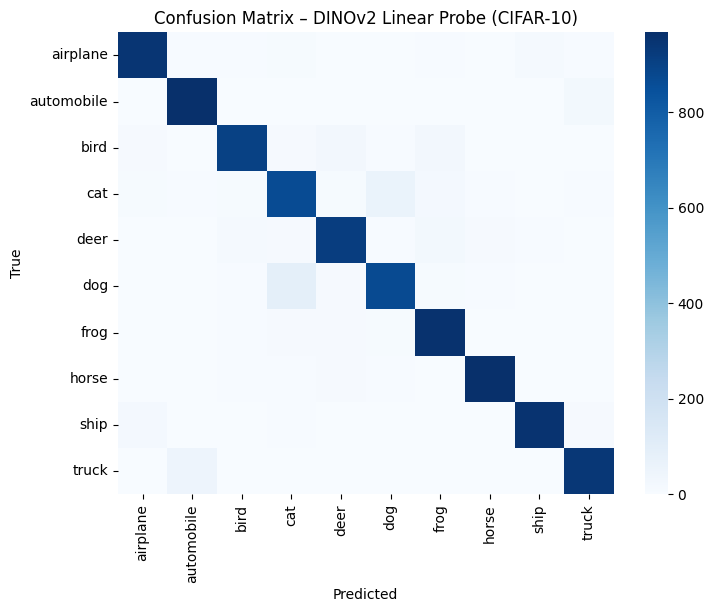

In [ ]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues", xticklabels=train_set.classes,
            yticklabels=train_set.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – DINOv2 Linear Probe (CIFAR-10)")
plt.show()